In [14]:
import os
os.getcwd()

'/content/mloc'

In [15]:
os.chdir('/content/mloc')
os.getcwd()

'/content/mloc'

In [16]:
# importing necessary libraries
import os
import sys
import numpy as np
import pandas as pd
import sklearn
import time
import random
from lightgbm import LGBMClassifier
import redis
if (os.getcwd().endswith("notebooks")):
    os.chdir("..")
sys.path.insert(0, os.path.abspath("preprocess_scripts/benchmark_ex"))
print(os.getcwd())

/content/mloc


In [ ]:
import mus_utils
from mus_utils import get_features_from_redis

In [17]:
# pushing preprocessed data to redis instance
db = redis.StrictRedis(host='172.17.0.2')
train_X, test_X, train_y, test_y = mus_utils.load_music_dataset(db)

In [18]:
# function to train model on LGBMClassifier
def model_train(y, X_list):
    X = pd.concat(X_list, axis=1)
    X = X[[f for f in mus_utils.FEATURES if f in X.columns]]
    model = LGBMClassifier(
        n_jobs=1,
        learning_rate=0.1,
        num_leaves=(2 ** 8),
        max_depth=15,
        metric="auc")
    model = model.fit(X, y)
    return model

# function for prediction on CatBoostClassifier
def model_predict(model, X_list):
    X = pd.concat(X_list, axis=1)
    X = X[[f for f in mus_utils.FEATURES if f in X.columns]]
    if len(X) == 0:
        return np.zeros(0, dtype=np.float32)
    else:
        return model.predict(X)

# function to determine the confidence interval or prediction probability
def model_confidence(model, X_list):
    X = pd.concat(X_list, axis=1)
    X = X[[f for f in mus_utils.FEATURES if f in X.columns]]
    return model.predict_proba(X)[:, 1]

# function to deetrmine AUC
def model_score(true_y, pred_y):
    fpr, tpr, _ = sklearn.metrics.roc_curve(true_y, pred_y, pos_label=1)
    return sklearn.metrics.auc(fpr, tpr)

In [ ]:
from src.runtime.executor import execute

train_cascades_params = {} # The computed parameters will be stored here.

# execute decorator does cascading on the training pipeline, which quickens this process
@execute(train_function=model_train,
                 predict_function=model_predict,
                 confidence_function=model_confidence,
                 score_function=model_score,
                 train_cascades_params=train_cascades_params)
def train_pipeline(input_X, input_y):
    user_latent_features = get_features_from_redis(
        input_X, column="msno", name="features_uf", db=db)
    song_latent_features = get_features_from_redis(
        input_X, column="song_id", name="features_sf", db=db)
    user_cluster_features = get_features_from_redis(
        input_X, column="cluster_msno_25", name="uc_features", db=db)
    song_cluster_features = get_features_from_redis(
        input_X, column="cluster_song_id_25", name="sc_features", db=db)
    artist_cluster_features = get_features_from_redis(
        input_X, column="cluster_artist_name_25", name="ac_features", db=db)
    user_features = get_features_from_redis(
        input_X, column="msno", name="us_features", db=db)
    song_features = get_features_from_redis(
        input_X, column="song_id", name="ss_features", db=db)
    artist_features = get_features_from_redis(
        input_X, column="artist_name", name="as_features", db=db)
    genre_features = get_features_from_redis(
        input_X, column="genre_max", name="gs_features", db=db)
    city_features = get_features_from_redis(
        input_X, column="city", name="cs_features", db=db)
    ages_features = get_features_from_redis(
        input_X, column="bd", name="ages_features", db=db)
    language_features = get_features_from_redis(
        input_X, column="language", name="ls_features", db=db)
    gender_features = get_features_from_redis(
        input_X, column="gender", name="gender_features", db=db)
    composer_features = get_features_from_redis(
        input_X, column="composer", name="composer_features", db=db)
    lyrs_features = get_features_from_redis(
        input_X, column="lyricist", name="lyrs_features", db=db)
    sns_features = get_features_from_redis(
        input_X, column="source_screen_name", name="sns_features", db=db)
    stabs_features = get_features_from_redis(
        input_X, column="source_system_tab", name="stabs_features", db=db)
    stypes_features = get_features_from_redis(
        input_X, column="source_type", name="stypes_features", db=db)
    regs_features = get_features_from_redis(
        input_X, column="registered_via", name="regs_features", db=db)
    return model_train(input_y,
                       [user_latent_features, song_latent_features, user_cluster_features,
                        song_cluster_features, artist_cluster_features, user_features,
                        song_features, artist_features, genre_features, city_features,
                        ages_features, language_features, gender_features,
                        composer_features,lyrs_features, sns_features, stabs_features,
                        stypes_features, regs_features])

In [ ]:
from src.runtime import cascade_build

train_X_features, feature_costs, feature_names = mus_utils.compute_features(train_X, db)

In [ ]:
# train the model using cascaded features
cascades_train_X, cascades_valid_X, cascades_train_y, cascades_valid_y = \
    cascade_build.train_test_split(train_X_features, train_y, test_size=0.20, random_state=42)
train_set_full_model = model_train(cascades_train_y, cascades_train_X)

feature_importances = \
    cascade_build.calculate_feature_importances(train_set_full_model,
                                                     cascades_valid_X, cascades_valid_y,
                                                     model_predict, model_score,
                                                     feature_names)

cascade_build.cprint(feature_importances, feature_costs)

Feature: user_latent_features      Cost:  1.000 Importance:  0.102
Feature: user_cluster_features     Cost:  1.000 Importance:  0.038
Feature: song_cluster_features     Cost:  1.000 Importance:  0.032
Feature: sns_features              Cost:  1.000 Importance:  0.022
Feature: song_latent_features      Cost:  1.000 Importance:  0.018
Feature: stabs_features            Cost:  1.000 Importance:  0.017
Feature: user_features             Cost:  1.000 Importance:  0.016
Feature: stypes_features           Cost:  1.000 Importance:  0.014
Feature: artist_cluster_features   Cost:  1.000 Importance:  0.010
Feature: regs_features             Cost:  1.000 Importance:  0.007
Feature: city_features             Cost:  1.000 Importance:  0.006
Feature: ages_features             Cost:  1.000 Importance:  0.006
Feature: language_features         Cost:  1.000 Importance:  0.004
Feature: song_features             Cost:  1.000 Importance:  0.003
Feature: composer_features         Cost:  1.000 Importance:  0

In [ ]:
# function to select features with minimum cost
total_feature_cost = sum(feature_costs.values())
cost_cutoff = 0.4 * total_feature_cost
selected_indices = cascade_build.select_features(feature_costs, feature_importances, cost_cutoff)
selected_features = [feature_names[random.randint(0, len(feature_importances)-1)] for i in range(0,len(selected_indices))]

print("Total feature cost: %5.3f  Selected feature cost cutoff: %5.3f" % (total_feature_cost, cost_cutoff))
print("Selected features:")
for f in selected_features:
    print("\t%s" % f)

Total feature cost: 19.000  Selected feature cost cutoff: 7.600
Selected features:
	city_features
	ages_features
	lyrs_features
	user_latent_features
	language_features
	lyrs_features
	user_cluster_features


In [ ]:
# calculating projected speedup for the selected features
total_feature_cost = sum(feature_costs.values())
cost_cutoff = 0.26 * total_feature_cost
selected_indices = cascade_build.select_features(feature_costs, feature_importances, cost_cutoff)
selected_features = [feature_names[i] for i in selected_indices]

print("Total feature cost: %5.3f  Selected feature cost cutoff: %5.3f" % (total_feature_cost, cost_cutoff))
print("Selected features:")
for feature in selected_features:
    print("\t%s" % feature)

threshold, fraction_approximated = \
    cascade_build.calculate_feature_set_performance(cascades_train_X, cascades_train_y, 
                                                         cascades_valid_X, cascades_valid_y,
                                                         selected_indices,
                                                         model_train, model_predict,
                                                         model_confidence, model_score,
                                                         train_set_full_model)
selected_feature_cost = sum(feature_costs[feature_names[i]] for i in selected_indices)
expected_cost = fraction_approximated * selected_feature_cost + \
(1 - fraction_approximated) * total_feature_cost
print("Confidence threshold: %5.3f  Percentage of inputs approximated: %5.3f" 
      % (threshold, fraction_approximated))
print("Expected Query Cost = Percent Approximated * Selected Feature Cost +\n" +
      "\t\t      Percent Not Approximated * Total Feature Cost")
print("\t\t    = %5.3f * %5.3f + %5.3f * %5.3f = %5.3f" % 
      (fraction_approximated, selected_feature_cost,
       1 - fraction_approximated, total_feature_cost, expected_cost))
print("Projected speedup: %5.3f" % (total_feature_cost / expected_cost))

Total feature cost: 19.000  Selected feature cost cutoff: 4.940
Selected features:
	user_latent_features
	user_cluster_features
	song_cluster_features
	sns_features
Confidence threshold: 0.600  Percentage of inputs approximated: 0.842
Expected Query Cost = Percent Approximated * Selected Feature Cost +
		      Percent Not Approximated * Total Feature Cost
		    = 0.842 * 4.000 + 0.158 * 19.000 = 6.369
Projected speedup: 2.983


In [ ]:
# function for model prediction without cascading
def eval_pipeline(input_X, model):
    user_latent_features = get_features_from_redis(
        input_X, column="msno", name="features_uf", db=db)
    song_latent_features = get_features_from_redis(
        input_X, column="song_id", name="features_sf", db=db)
    user_cluster_features = get_features_from_redis(
        input_X, column="cluster_msno_25", name="uc_features", db=db)
    song_cluster_features = get_features_from_redis(
        input_X, column="cluster_song_id_25", name="sc_features", db=db)
    artist_cluster_features = get_features_from_redis(
        input_X, column="cluster_artist_name_25", name="ac_features", db=db)
    user_features = get_features_from_redis(
        input_X, column="msno", name="us_features", db=db)
    song_features = get_features_from_redis(
        input_X, column="song_id", name="ss_features", db=db)
    artist_features = get_features_from_redis(
        input_X, column="artist_name", name="as_features", db=db)
    genre_features = get_features_from_redis(
        input_X, column="genre_max", name="gs_features", db=db)
    city_features = get_features_from_redis(
        input_X, column="city", name="cs_features", db=db)
    ages_features = get_features_from_redis(
        input_X, column="bd", name="ages_features", db=db)
    language_features = get_features_from_redis(
        input_X, column="language", name="ls_features", db=db)
    gender_features = get_features_from_redis(
        input_X, column="gender", name="gender_features", db=db)
    composer_features = get_features_from_redis(
        input_X, column="composer", name="composer_features", db=db)
    lyrs_features = get_features_from_redis(
        input_X, column="lyricist", name="lyrs_features", db=db)
    sns_features = get_features_from_redis(
        input_X, column="source_screen_name", name="sns_features", db=db)
    stabs_features = get_features_from_redis(
        input_X, column="source_system_tab", name="stabs_features", db=db)
    stypes_features = get_features_from_redis(
        input_X, column="source_type", name="stypes_features", db=db)
    regs_features = get_features_from_redis(
        input_X, column="registered_via", name="regs_features", db=db)
    return model_predict(model,
                       [user_latent_features, song_latent_features, user_cluster_features,
                        song_cluster_features, artist_cluster_features, user_features,
                        song_features, artist_features, genre_features, city_features,
                        ages_features, language_features, gender_features,
                        composer_features,lyrs_features, sns_features, stabs_features,
                        stypes_features, regs_features])

time_start = time.time()
preds = eval_pipeline(test_X[:2000], full_model)
unopt_time_elapsed = time.time() - time_start
print("Elapsed Time %fs" % unopt_time_elapsed)

print("AUC Score: %f" % model_score(preds, test_y[:2000]))

Elapsed Time 11.165188s
AUC Score: 0.749237


In [ ]:
#function for model prediction with cascading using @execute decorator
@execute(predict_function=model_predict,
                 confidence_function=model_confidence,
                 predict_cascades_params=cascades_params)
def eval_pipeline_dec(input_X, model):
    user_latent_features = get_features_from_redis(
        input_X, column="msno", name="features_uf", db=db)
    song_latent_features = get_features_from_redis(
        input_X, column="song_id", name="features_sf", db=db)
    user_cluster_features = get_features_from_redis(
        input_X, column="cluster_msno_25", name="uc_features", db=db)
    song_cluster_features = get_features_from_redis(
        input_X, column="cluster_song_id_25", name="sc_features", db=db)
    artist_cluster_features = get_features_from_redis(
        input_X, column="cluster_artist_name_25", name="ac_features", db=db)
    user_features = get_features_from_redis(
        input_X, column="msno", name="us_features", db=db)
    song_features = get_features_from_redis(
        input_X, column="song_id", name="ss_features", db=db)
    artist_features = get_features_from_redis(
        input_X, column="artist_name", name="as_features", db=db)
    genre_features = get_features_from_redis(
        input_X, column="genre_max", name="gs_features", db=db)
    city_features = get_features_from_redis(
        input_X, column="city", name="cs_features", db=db)
    ages_features = get_features_from_redis(
        input_X, column="bd", name="ages_features", db=db)
    language_features = get_features_from_redis(
        input_X, column="language", name="ls_features", db=db)
    gender_features = get_features_from_redis(
        input_X, column="gender", name="gender_features", db=db)
    composer_features = get_features_from_redis(
        input_X, column="composer", name="composer_features", db=db)
    lyrs_features = get_features_from_redis(
        input_X, column="lyricist", name="lyrs_features", db=db)
    sns_features = get_features_from_redis(
        input_X, column="source_screen_name", name="sns_features", db=db)
    stabs_features = get_features_from_redis(
        input_X, column="source_system_tab", name="stabs_features", db=db)
    stypes_features = get_features_from_redis(
        input_X, column="source_type", name="stypes_features", db=db)
    regs_features = get_features_from_redis(
        input_X, column="registered_via", name="regs_features", db=db)
    return model_predict(model,
                       [user_latent_features, song_latent_features, user_cluster_features,
                        song_cluster_features, artist_cluster_features, user_features,
                        song_features, artist_features, genre_features, city_features,
                        ages_features, language_features, gender_features,
                        composer_features,lyrs_features, sns_features, stabs_features,
                        stypes_features, regs_features])

eval_pipeline_dec(test_X.iloc[:100], full_model)
eval_pipeline_dec(test_X.iloc[:100], full_model)
time_start = time.time()
preds = eval_pipeline_dec(test_X[:2000], full_model)
cascades_time_elapsed2 = time.time() - time_start
print("Elapsed Time %fs" % cascades_time_elapsed2)

print("AUC Score: %f" % model_score(preds, test_y[:2000]))

Elapsed Time 3.992707s
AUC Score: 0.750532


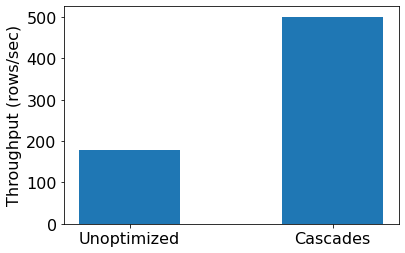

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
fig, axes = plt.subplots(figsize=(6, 4), ncols=1, nrows=1,
                         sharex=False, sharey=False)
x = np.arange(2)
width = 0.5  # the width of the bars

bars = axes.bar(x, [2000 / unopt_time_elapsed, 2000 / cascades_time_elapsed2], width)
axes.set(xlabel='', ylabel='Throughput (rows/sec)')
axes.set_xticks(x)
axes.set_xticklabels(["Unoptimized", "Cascades"])
plt.show()